In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('income.csv')

df = df.rename(columns={'marital-status': 'maritalstatus'})
df = df.rename(columns={'native-country': 'nativecountry'})

df['old_employers'] = np.where(df['age'] >= 50, 1, 0).astype(int)
df.old_employers = df.old_employers.astype('category')
df.workclass = df.workclass.astype('category')
df.education = df.education.astype('category')
df.maritalstatus = df.maritalstatus.astype('category')
df.occupation = df.occupation.astype('category')
df.relationship = df.relationship.astype('category')
df.race = df.race.astype('category')
df.sex = df.sex.astype('category')
df.nativecountry = df.nativecountry.astype('category')

Y = df['old_employers'] # выбираем целевую переменную (категориальную)
X = df.drop('old_employers', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('age', axis=1)

Y.info()


df.drop('age', axis=1).info()

<class 'pandas.core.series.Series'>
RangeIndex: 32561 entries, 0 to 32560
Series name: old_employers
Non-Null Count  Dtype   
--------------  -----   
32561 non-null  category
dtypes: category(1)
memory usage: 32.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   workclass       30725 non-null  category
 1   education       32561 non-null  category
 2   education-num   32561 non-null  int64   
 3   maritalstatus   32561 non-null  category
 4   occupation      30718 non-null  category
 5   relationship    32561 non-null  category
 6   race            32561 non-null  category
 7   sex             32561 non-null  category
 8   capital-gain    32561 non-null  int64   
 9   capital-loss    32561 non-null  int64   
 10  hours-per-week  32561 non-null  int64   
 11  nativecountry   31978 non-null  category
 12  income >50K     32561 no

In [4]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.

     


In [6]:
Y.value_counts()

old_employers
0    25499
1     7062
Name: count, dtype: int64

In [8]:
from sklearn.utils import resample

# Объединяем X и y для удобства
data = pd.concat([X, Y], axis=1)

# Разделяем на классы
majority = data[data['old_employers'] == 0]
minority = data[data['old_employers'] == 1]

# Уменьшаем количество экземпляров класса 1
minority_downsampled = resample(minority,
                                replace=False,
                                n_samples=int(len(majority)*0.1),
                                random_state=42)

# Объединяем обратно
data_disbalanced = pd.concat([majority, minority_downsampled])

# Новые X и y
X_disbalanced = data_disbalanced.drop('old_employers', axis=1)
Y_disbalanced = data_disbalanced['old_employers']

     

In [10]:
print(Y_disbalanced.value_counts())


old_employers
0    25499
1     2549
Name: count, dtype: int64


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_disbalanced, Y_disbalanced, test_size=0.3, random_state=42)

# Обучаем модель
model = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

In [12]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9114676173499703

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      7670
           1       0.00      0.00      0.00       745

    accuracy                           0.91      8415
   macro avg       0.46      0.50      0.48      8415
weighted avg       0.83      0.91      0.87      8415



/Users/kirillzuenko/VSCProjects/ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kirillzuenko/VSCProjects/ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kirillzuenko/VSCProjects/ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [13]:
unique, counts = np.unique(y_pred, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # данная ситуация называется переобучением. Модель очень хорошо обучилась на 0, настол

{np.int64(0): np.int64(8415)}

In [15]:
# Уменьшаем количество экземпляров класса 0
majority_downsampled = resample(majority,
                                replace=False,
                                n_samples=len(minority),
                                random_state=42)

# Объединяем обратно
data_balanced = pd.concat([majority_downsampled, minority])

# Новые X и y
X_balanced = data_balanced.drop('old_employers', axis=1)
Y_balanced = data_balanced['old_employers']

In [17]:
print(Y_balanced.value_counts())

old_employers
0    7062
1    7062
Name: count, dtype: int64


In [19]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, Y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)


In [20]:

print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))

Accuracy: 0.5283152430391694

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.90      0.65      2109
           1       0.61      0.16      0.26      2129

    accuracy                           0.53      4238
   macro avg       0.56      0.53      0.46      4238
weighted avg       0.56      0.53      0.46      4238



In [21]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить
     

{np.int64(0): np.int64(3668), np.int64(1): np.int64(570)}

In [23]:
# Выбираем числовые признаки
numeric_features = X_balanced.select_dtypes(include=['int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_balanced[numeric_features] = scaler.fit_transform(X_balanced[numeric_features])


In [25]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, Y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [26]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal)) # Дополнительно получили 1.57% точности, отлично!


Accuracy: 0.7168475696083058

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.63      0.69      2109
           1       0.69      0.80      0.74      2129

    accuracy                           0.72      4238
   macro avg       0.72      0.72      0.71      4238
weighted avg       0.72      0.72      0.71      4238



In [27]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить

{np.int64(0): np.int64(1769), np.int64(1): np.int64(2469)}

In [28]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, Y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)


In [29]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Вычисляем матрицу ошибок (TP, FP, TN, FN)
conf_matrix = confusion_matrix(y_test_bal, y_pred_bal)
tn, fp, fn, tp = conf_matrix.ravel()

# Рассчитываем метрики
accuracy = accuracy_score(y_test_bal, y_pred_bal)
precision = precision_score(y_test_bal, y_pred_bal)
recall = recall_score(y_test_bal, y_pred_bal)
f1 = f1_score(y_test_bal, y_pred_bal)
roc_auc = roc_auc_score(y_test_bal, y_pred_bal)

# Генерируем classification_report
class_report = classification_report(y_test_bal, y_pred_bal, output_dict=True)

# Формируем результаты для наглядного вывода
results = {
    "True Negatives (TN)": tn,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn,
    "True Positives (TP)": tp,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc,
}

# Округляем все значения в словаре до двух знаков после запятой и возвращаем в виде dict.items()
rounded_items = {k: round(v, 2) for k, v in results.items()}

In [30]:
print(classification_report(y_test_bal, y_pred_bal))

              precision    recall  f1-score   support

           0       0.76      0.63      0.69      2109
           1       0.69      0.80      0.74      2129

    accuracy                           0.72      4238
   macro avg       0.72      0.72      0.71      4238
weighted avg       0.72      0.72      0.71      4238



Precision (точность):

    Для класса 0: 0.76 — довольно хорошая точность, что означает, что большинство предсказанных объектов класса 0 действительно принадлежат этому классу.
    Для класса 1: 0.69 — ниже, что указывает на больший уровень ложных срабатываний для этого класса.

Recall (полнота):

    Для класса 0: 0.63 — относительно низкая полнота, значит модель пропускает много объектов, которые на самом деле принадлежат классу 0.
    Для класса 1: 0.80 — выше, модель хорошо идентифицирует объекты этого класса, но возможно за счёт большего количества ложных положительных.

F1-score:

    Для класса 0: 0.69 — баланс между точностью и полнотой, что подтверждает слабость модели в распознавании класса 0.
    Для класса 1: 0.74 — немного выше, но всё ещё требует улучшений.

In [31]:
conf_matrix # Матрица
# TN FP
# FN TP

array([[1339,  770],
       [ 430, 1699]])

In [32]:
rounded_items

{'True Negatives (TN)': np.int64(1339),
 'False Positives (FP)': np.int64(770),
 'False Negatives (FN)': np.int64(430),
 'True Positives (TP)': np.int64(1699),
 'Accuracy': 0.72,
 'Precision': np.float64(0.69),
 'Recall': np.float64(0.8),
 'F1-score': np.float64(0.74),
 'ROC-AUC': np.float64(0.72)}

In [44]:
y = df['hours-per-week']

X = df.drop(['hours-per-week', 'old_employers'], axis=1)

In [45]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.

     

In [46]:
X

,age,education-num,capital-gain,capital-loss,income >50K,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,nativecountry_Portugal,nativecountry_Puerto-Rico,nativecountry_Scotland,nativecountry_South,nativecountry_Taiwan,nativecountry_Thailand,nativecountry_Trinadad&Tobago,nativecountry_United-States,nativecountry_Vietnam,nativecountry_Yugoslavia
0,39,13,2174,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,13,0,0,0,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,38,9,0,0,0,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
3,53,7,0,0,0,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,28,13,0,0,0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,12,0,0,0,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
32557,40,9,0,0,1,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
32558,58,9,0,0,0,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
32559,22,9,0,0,0,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False


In [47]:
from sklearn.tree import DecisionTreeClassifier
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)
     

In [48]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))



Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         9
           4       0.33      0.05      0.08        21
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00        44
           9       0.00      0.00      0.00         3
          10       0.25      0.08      0.13        83
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00        13
          15       0.08      0.02      0.04       131
          16       0.13      0.03      0.04        76
          17       0.00      0.00      0.00         5
  

/Users/kirillzuenko/VSCProjects/ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kirillzuenko/VSCProjects/ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kirillzuenko/VSCProjects/ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [49]:
accuracy_score(y_test_multi, y_pred_multi)

0.45767222847783806

In [50]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_multi, y_pred_multi) # ну такое


np.float64(0.017528203444814178)

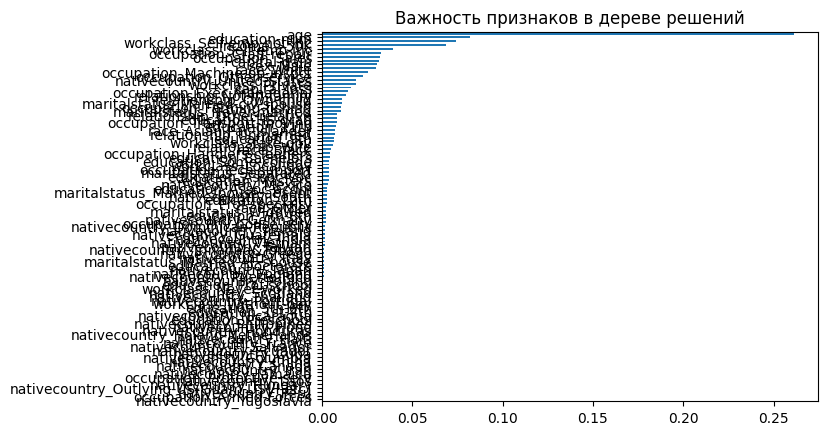

In [52]:

import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()


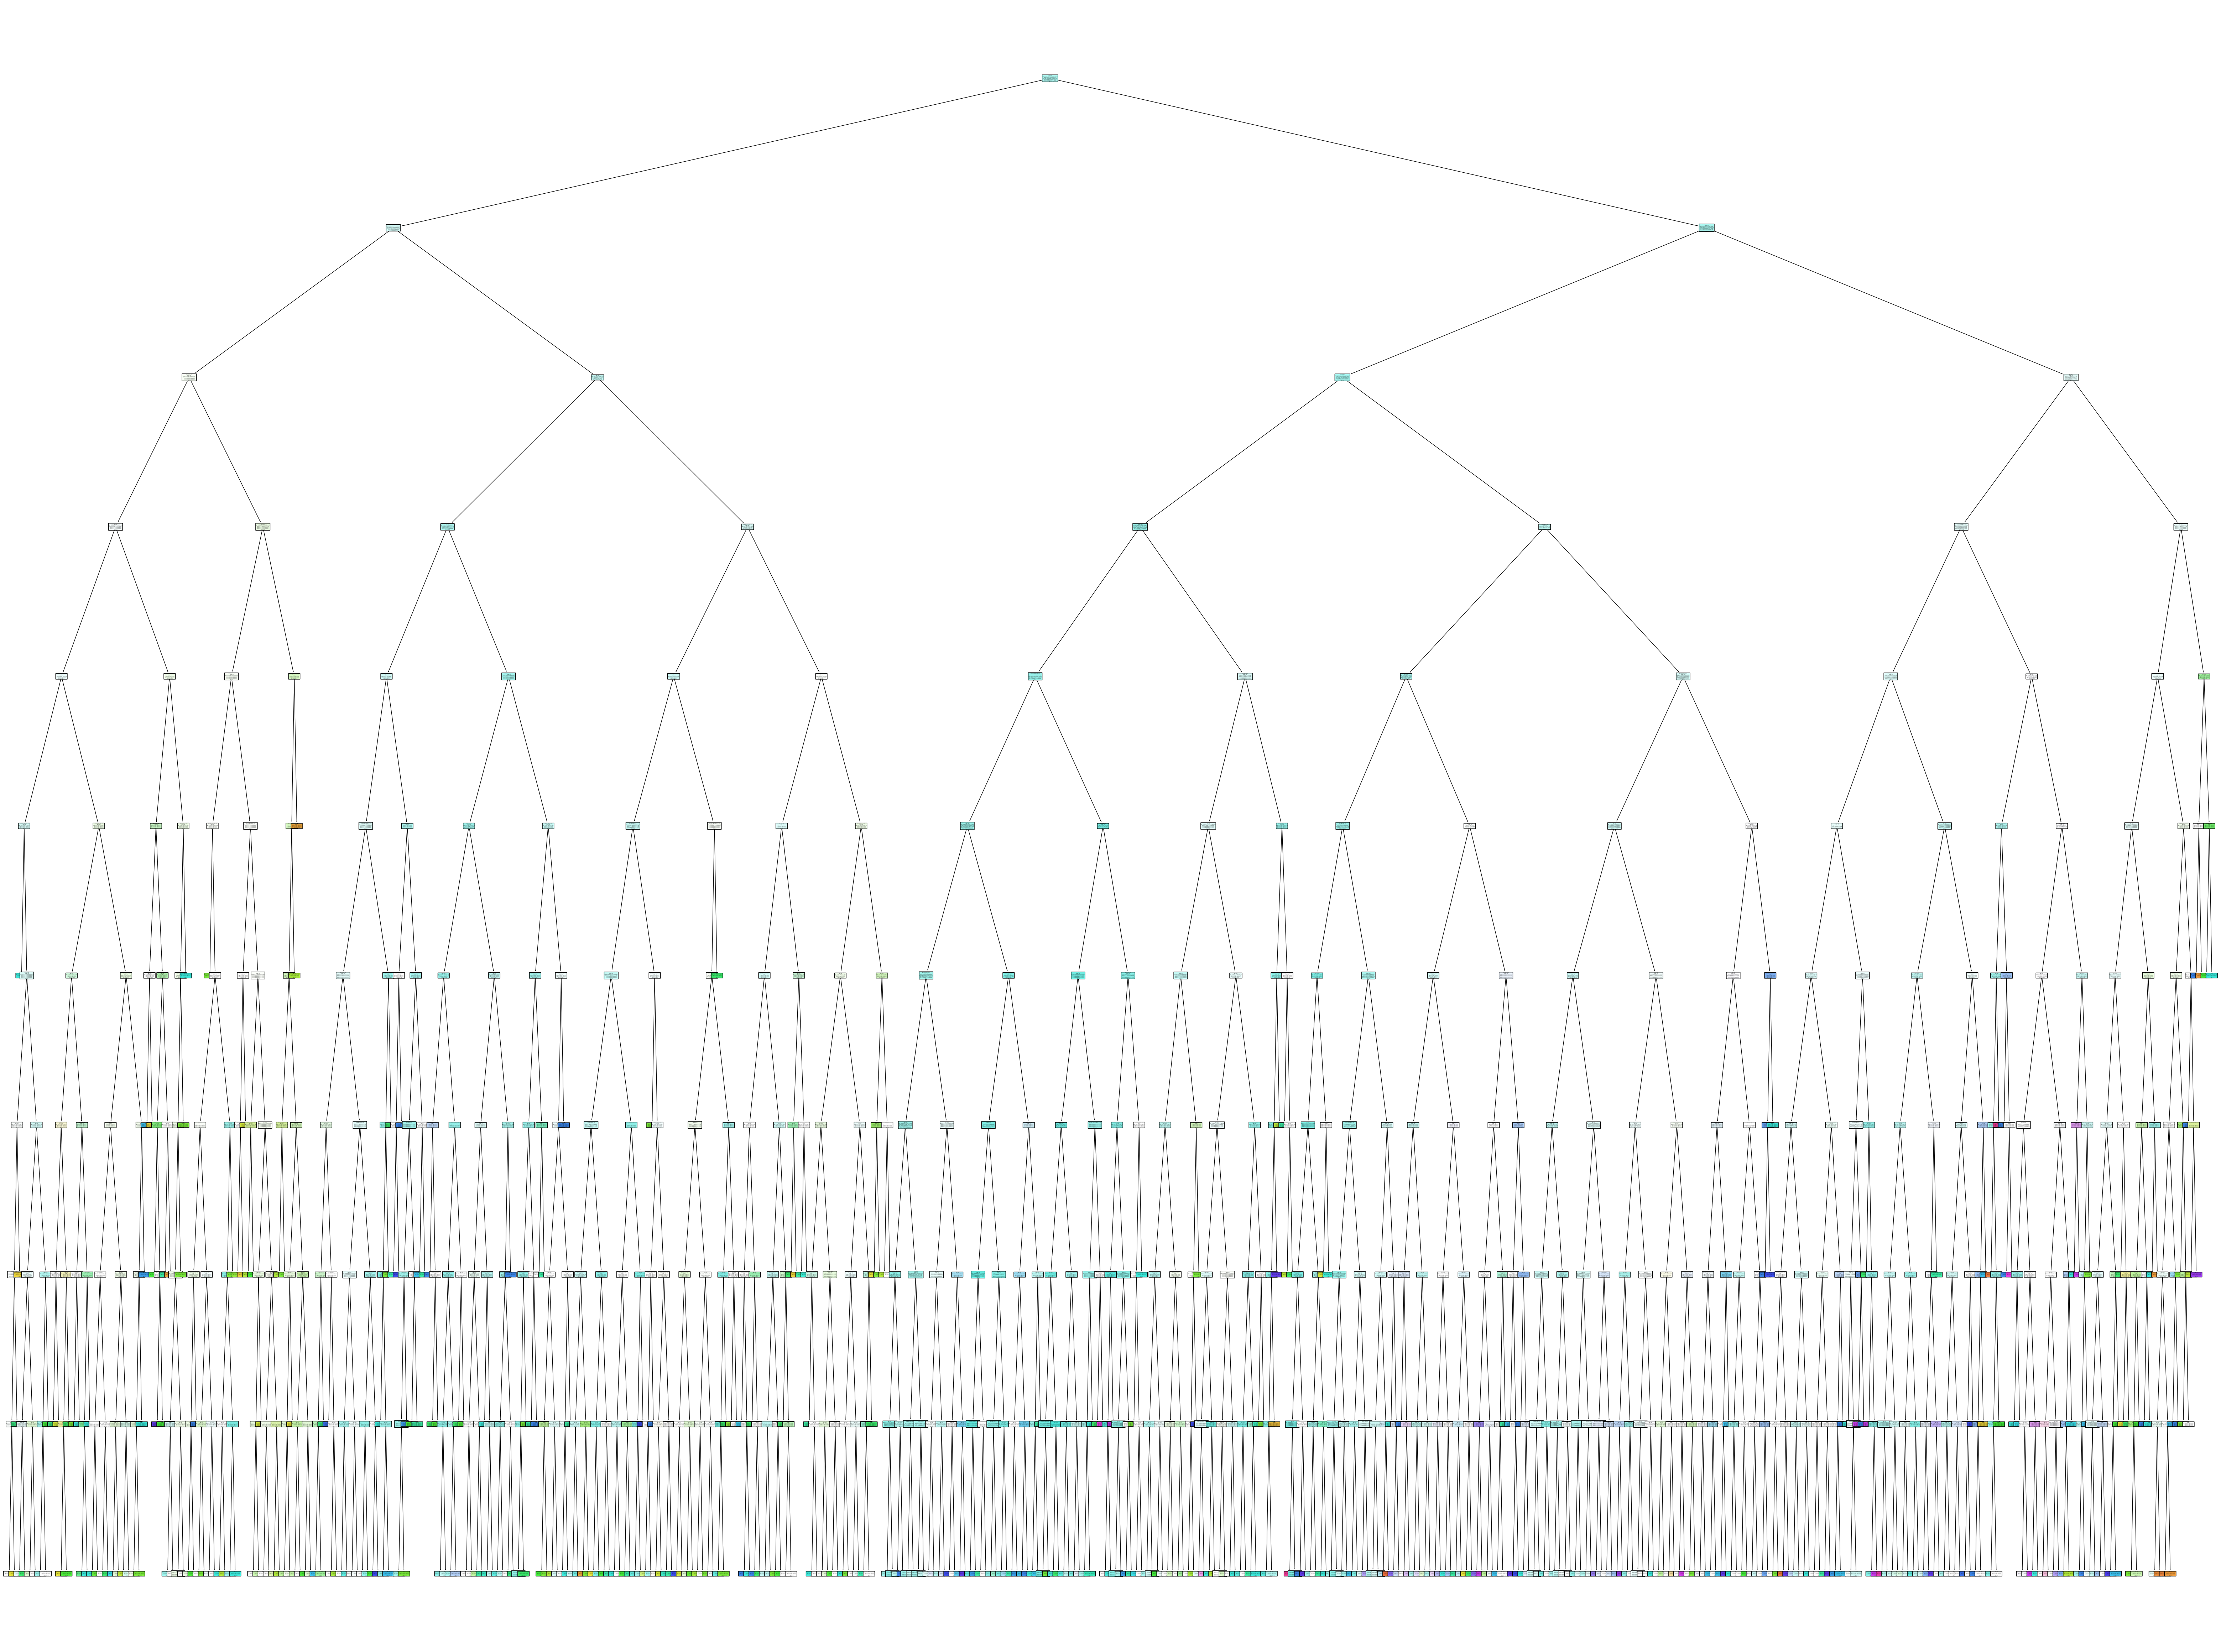

In [53]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X.columns, class_names=[str(item) for item in sorted(y.unique())], filled=True, rounded=True)
plt.show()
